In [2]:
import os
import glob
import time
import json
import heapq
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pickle
import torch
from tqdm import tqdm
import seaborn as sns
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from typing import Union
import networkx as nx

from env.graph_env import copy_graph, Indices, is_stable, in_table_index, get_node_poses
from env.graph_env import create_graph, flatten_pos, unflatten_pos

In [1]:
DEFAULT_SIZES = {
		# non-container
		0: (7, 7), # fork, spoon, knife  /  yellow
		1: (11, 11), # apple, pear  /  orange
		2: (17, 17), # banana  /  orange
		# container
		3: (11, 11), # cup, mug  /  green
		4: (17, 17), # bowl  /  green
		5: (21, 21), # basket, box  /  blue
		6: (27, 27), # pan  /  blue
	}

def copy_state(state):
	return {'graph': copy_graph(state['graph']), 'manipulator': state['manipulator'].clone()}

def find_target_obj(graph, node):
	i = (graph.x[node, Indices.RELATION] == 1).nonzero(as_tuple=True)[0]
	if len(i):
		return i.item()
	return None

def find_start_obj(graph, node):
	i = (graph.x[:, Indices.RELATION.start + node] == 1).nonzero(as_tuple=True)[0]
	if len(i):
		return i.item()
	return None

def is_empty_object(graph, node):
	return find_start_obj(graph, node) is None

def is_edge_in_graph(graph, node1, node2):
	if graph.x[node1, Indices.RELATION.start + node2] == 0:
		return False
	return True

def is_stacked_object(graph, node):
	return graph.x[node, Indices.RELATION].sum() > 0

def is_in_env(coor, size, grid_size):
	if coor[0] - size[0]//2 < 0 or coor[0] + size[0]//2 >= grid_size[0]:
		return False
	if coor[1] - size[1]//2 < 0 or coor[1] + size[1]//2 >= grid_size[1]:
		return False
	return True

def find_base_obj(graph, node):
	while is_stacked_object(graph, node):
		node = find_target_obj(graph, node)
	return node

def find_occupying_objs(table, coor, size):
	occupying_objs = []
	unique_nums = np.unique(table[in_table_index(coor, size)])

	for num in unique_nums:
		if num == 0:
			continue
		occupying_objs.append(num-1)

	return occupying_objs

def get_obj_pos(graph, node):
	return graph.x[node, Indices.COORD].clone()

def get_obj_size(graph, node):
	return graph.x[node, Indices.SIZE].clone().tolist()

def get_obj_label(graph, node):
	return graph.x[node, Indices.LABEL].item()

def get_empty_objs(env, ref_node, n=1):
	all_objects = list(range(env.num_objects))
	np.random.shuffle(all_objects)

	empty_objs = []
	for obj in all_objects:
		if is_empty_object(env.state_graph, obj) and is_stable(env.state_graph.x, ref_node, obj):
			empty_objs.append(obj)
			if len(empty_objs) >= n:
				break
			
	return empty_objs

def get_all_positions_of_object(coord, size):
    idx = in_table_index(coord, size)
    x_range = np.arange(idx[0].start, idx[0].stop)
    y_range = np.arange(idx[1].start, idx[1].stop)
    x, y = np.meshgrid(x_range, y_range, indexing='ij')
    return np.column_stack((x.ravel(), y.ravel()))

def score(env, coor, obj):
	dis_obj = torch.norm(get_obj_pos(env.target_graph, obj) - coor).item()
	return env.occupied_score(coor, obj) + dis_obj * env.normalization_factor

def get_all_positions_in_env(grid_size, size):
    x_range = np.arange(size[0] // 2, grid_size[0] - size[0] // 2)
    y_range = np.arange(size[1] // 2, grid_size[1] - size[1] // 2)
    x, y = np.meshgrid(x_range, y_range, indexing='ij')
    return np.column_stack((x.ravel(), y.ravel()))

def get_empty_positions(env, ref_node, n=1, sort=False):
	ref_size = get_obj_size(env.state_graph, ref_node)
	all_positions = get_all_positions_in_env(env.grid_size, ref_size)
	if sort:
		all_positions = sorted(all_positions, key=lambda x: score(env, x, ref_node))
	else:
		np.random.shuffle(all_positions)

	positions = []
	for position in all_positions:
		position = torch.tensor(position, dtype=torch.float32)
		if not env.is_coor_occupied(position, ref_node):
			positions.append(flatten_pos(position, env.grid_size))
			if len(positions) >= n:
				break

	return positions

def get_empty_positions_with_target(env, ref_node, n=1, sort=False):
	positions = []
	target_pos = get_obj_pos(env.target_graph, ref_node)
	if not env.is_coor_occupied(target_pos, ref_node):
		# TK is free
		positions.append(flatten_pos(target_pos, env.grid_size))
	else:
		if n == 0:
			return positions
		# Choose random buffer position
		for position in get_empty_positions(env, ref_node=ref_node, n=n+1, sort=sort):
			if position != flatten_pos(target_pos, env.grid_size):
				positions.append(position)
				if len(positions) >= n:
					break
	return positions

def draw_dependency_graph(env, fig_size=(2.5, 2.5)):
	dependency_graph = nx.DiGraph()
	for k in range(env.num_objects):
		dependency_graph.add_node(k)
		i = find_target_obj(env.target_graph, k)
		if i is None:
			j = find_target_obj(env.state_graph, k)
			CK = get_obj_pos(env.state_graph, k)
			TK = get_obj_pos(env.target_graph, k)
			if torch.equal(CK, TK):
				while j is not None:
					if not dependency_graph.has_edge(k, j):
						dependency_graph.add_edge(k, j)
					j = find_target_obj(env.state_graph, j)
			else:
				size_k = get_obj_size(env.state_graph, k)
				occupying_nodes = find_occupying_objs(env.table, TK, size_k)
				for j in occupying_nodes:
					if j != k:
						j = find_base_obj(env.state_graph, j)
						if not dependency_graph.has_edge(k, j):
							dependency_graph.add_edge(k, j)
		else:
			j = find_start_obj(env.state_graph, i)
			if j is not None and j != k:
				dependency_graph.add_edge(k, j)

	fig, ax = plt.subplots(1, 1, figsize=fig_size)
	nx.draw(dependency_graph, env.state_graph.pos, with_labels=True, node_size=400, ax=ax, node_color='skyblue')
	plt.title('Dependency Graph')
	plt.show()

def draw_manipulator_decoding(env):
	height_grid, width_grid = env.grid_size
	table = np.zeros(env.grid_size, dtype=int)

	for i in range(height_grid):
		for j in range(width_grid):
			table[i, j] = env.manipulator_decode([i, j])[0]

	plt.imshow(table, cmap='viridis')
	plt.show()

def env_cost(env, actions, initial_scene, target_scene, log=True):
	env.reset(initial_scene, target_scene)
	if actions is None:
		return None
	
	ep_cost = 0
	for action in actions:
		ep_cost += env.step(action, log=log)[0]
	if log:
		print(f'episode cost: {ep_cost:.3f}')
	env.reset(initial_scene, target_scene)
	return ep_cost

def evaluate_alg(env, alg, initial_scene, target_scene, **kwargs):
	env.reset(initial_scene, target_scene)
	print(f"--------{alg.__name__}--------")
	plan, steps, elapsed_time = alg(env).solve(**kwargs)

	print(f'plan: {plan}')
	print(f'elapsed time: {elapsed_time:.2f}s | steps: {steps}')
	if plan is not None:
		env_cost(env, plan, initial_scene, target_scene)
	env.reset(initial_scene, target_scene)
	return plan

def positional_encode(one_hot_position):
	positions = torch.argmax(one_hot_position, dim=1)
	encodings = torch.zeros((len(positions), 1))

	for i, position in enumerate(positions):
		if torch.sum(one_hot_position[i]) == 0:
			encodings[i] = -1
		else:
			encodings[i] = position

	return encodings

def cal_density(graph, grid_size):
	phi = 0
	for i in range(graph.num_nodes):
		size_i = get_obj_size(graph, i)
		phi += (size_i[0] * size_i[1])

	return phi / (grid_size[0] * grid_size[1])

def evaluate_alg_n_times(env, alg, initial_scene, target_scene, num_runs=1, **kwargs):
	plan = None
	steps = []
	costs = []
	elapsed_time = []
	best_cost = np.inf

	print(f"--------{alg.__name__}--------")
	for i in range(num_runs):
		env.reset(initial_scene, target_scene)
		plan_i, steps_i, elapsed_time_i = alg(env).solve(**kwargs)
		if plan_i:
			cost = env_cost(env, plan_i, initial_scene, target_scene, log=False)
			if cost < best_cost:
				plan = plan_i
			costs.append(cost)
			steps.append(steps_i)
			elapsed_time.append(elapsed_time_i)
		# print('--')
	
	env.reset(initial_scene, target_scene)
	print(f'plan: {plan}')
	print(f'mean cost: {np.mean(costs):.2f}')
	print(f'mean elapsed_time: {np.mean(elapsed_time):.2f}s | mean steps: {np.mean(steps)}')
	
	return plan

def plot_graph(graph, grid_size, ax=None, fig_size=2.5, title=None, constraints=[]):
	if ax is None:
		fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size*(grid_size[1]/grid_size[0])))

	# Create a color grid based on the labels and the color dictionary
	color_by_label = {
		0: 'white',		# background
		1: 'yellow',
		2: 'orange',
		3: 'orange',
		4: 'green',
		5: 'green',
		6: 'blue',
		7: 'blue',
		8: 'red',		# manipulator
	}
	# color_by_label = {
	# 	0: 'white',		# background
	# 	1: 'yellow',
	# 	2: 'orange',
	# 	3: 'green',
	# 	4: 'blue',
	# 	5: 'red',		# manipulator
	# }

	# Map the table values to colormap indices
	mapped_table = np.zeros(grid_size, dtype=int)
	unrendered_nodes = list(range(graph.num_nodes))
	while len(unrendered_nodes) > 0:
		i = unrendered_nodes.pop(0)
		label_i = get_obj_label(graph, i)
		coor_i = get_obj_pos(graph, i).numpy()
		size_i = get_obj_size(graph, i)
		if is_stacked_object(graph, i):
			child = find_target_obj(graph, i)
			if child in unrendered_nodes:
				unrendered_nodes.append(i)
				continue
			if label_i == 0 and (get_obj_label(graph, child) in [3, 4]):
			# if label_i == 0 and get_obj_label(graph, child) == 2:
				size_i = (3, 3)
		mapped_table[in_table_index(coor_i, size_i)] = label_i + 1
	
	for i in range(len(constraints)):
		# if the type of constraints is tensor, convert it to int
		if isinstance(constraints[i], torch.Tensor):
			constraints = constraints[i].numpy()
		else:
			constraints = constraints[i]
		c_x, c_y = list(map(int, constraints))
		# mapped_table[c_x, c_y] = 5
		mapped_table[c_x, c_y] = 8

	# Create a color list based on the numbers in the table
	unique_values = np.unique(mapped_table)
	color_list = [color_by_label[val] for val in unique_values]

	# Create a colormap and a normalization based on the unique values
	cmap = ListedColormap(color_list)
	bounds = np.append(unique_values, unique_values[-1] + 1)
	norm = BoundaryNorm(bounds, cmap.N)

	# Plot the table
	ax.imshow(mapped_table, cmap=cmap, norm=norm, origin='upper')

	# Add gridlines for better visualization
	ax.set_xticks(np.arange(-0.5, mapped_table.shape[1], 1), minor=True)
	ax.set_yticks(np.arange(-0.5, mapped_table.shape[0], 1), minor=True)
	ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3)
	ax.tick_params(which='minor', bottom=False, left=False)

	# Remove major ticks
	ax.set_xticks([])
	ax.set_yticks([])

	# Add labels to cells for clarity
	for i in range(graph.num_nodes):
		coor_i = get_obj_pos(graph, i).numpy()
		label_i = get_obj_label(graph, i)
		size_i = get_obj_size(graph, i)
		if is_stacked_object(graph, i):
			child = find_target_obj(graph, i)
			if label_i == 0 and (get_obj_label(graph, child) in [3, 4]):
			# if label_i == 0 and get_obj_label(graph, child) == 2:
				size_i = (1, 1)
		ax.text(coor_i[1]-size_i[1]//2, coor_i[0]-size_i[0]//2, str(i), ha='center', va='center', color='black')
	
	if title is not None:
		ax.set_title(title)

def _save_scene(file_name, initial_scene, target_scene, grid_size):
	data = {
		'initial_scene': copy_graph(initial_scene),
		'target_scene': copy_graph(target_scene),
		'grid_size': grid_size,
	}
	with open(file_name, 'wb') as f:
		pickle.dump(data, f)

def save_scene(file_name, env):
	_save_scene(file_name, env.initial_graph, env.target_graph, env.grid_size)

def save_scene_json(file_name, grid_size, initial_scene, target_scene, id):
	num_objects = initial_scene.num_nodes
	
	# save the scene in a json file
	objs = []
	for obj in range(num_objects):
		obj_label = get_obj_label(initial_scene, obj)
		objs.append({
			'label': int(obj_label),
			'initial_pos': get_obj_pos(initial_scene, obj).tolist(),
			'initial_relation': initial_scene.x[obj, Indices.RELATION].clone().tolist(),
			'target_pos': get_obj_pos(target_scene, obj).tolist(),
			'target_relation': target_scene.x[obj, Indices.RELATION].clone().tolist(), 
			'size': get_obj_size(initial_scene, obj)
		})
	
	json_scene = {
		'id': id,
		'phi': cal_density(initial_scene, grid_size),
		'num_objects': num_objects,
		'grid_size': grid_size,
		'objects': objs
	}
	
	# Save the scene in a json file
	with open(f'{file_name}_{id}.json', 'w') as f:
		json.dump(json_scene, f, indent=4)
	print(f'Saved scene to {file_name}.json')

def load_scene(file_name):
	with open(file_name, 'rb') as f:
		data = pickle.load(f)
	initial_scene = copy_graph(data['initial_scene'])
	target_scene = copy_graph(data['target_scene'])
	grid_size = data['grid_size']
	return initial_scene, target_scene, grid_size, initial_scene.num_nodes


phi: 0.218 | uniform size: (7, 7)
Manipulator: [14.5 14.5]


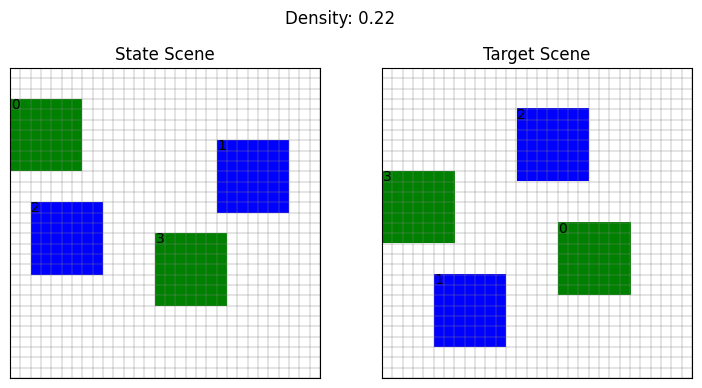

In [10]:
def get_obj_sizes(num_objects, grid_size, phi, verbose=0):
	object_sizes = DEFAULT_SIZES.copy()

	if phi == 'mix':
		if verbose > 0:
			print('Using default object sizes')
		return object_sizes

	phis = []
	for key in DEFAULT_SIZES.keys():
		object_sizes[key] = (1, 1)
	
	for _ in range(max(grid_size)//3):
		try:
			graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, p=0.0)
		except:
			break
		phis.append({cal_density(graph, grid_size): object_sizes.copy()})
		for key in object_sizes.keys():
			object_sizes[key] = (object_sizes[key][0]+2, object_sizes[key][1]+2)
	
	best_phi = min(phis, key=lambda x: abs(list(x.keys())[0] - phi))
	if verbose > 0:
		print(f'phi: {list(best_phi.keys())[0]:.3f} | uniform size: {list(best_phi.values())[0][0]}')
	
	return list(best_phi.values())[0]

class ContinuousEnv:
	def __init__(
			self, mode, 
			num_objects, grid_size, 
			moving_buff=True, terminal_cost=False, 
			phi='mix', verbose=1,
		):
		self.mode = mode
		self.num_objects = num_objects
		self.grid_size = grid_size
		self.moving_buff = moving_buff
		self.terminal_cost = terminal_cost
		self.verbose = verbose
		self.object_sizes = get_obj_sizes(num_objects, grid_size, phi, verbose=verbose)

		if self.mode == 'mobile':
			self.manipulator_initial_pos = torch.tensor([0, (self.grid_size[1]-1)/2], dtype=torch.float32)
		elif self.mode == 'stationary':
			self.manipulator_initial_pos = torch.tensor([(self.grid_size[0]-1)/2, (self.grid_size[1]-1)/2], dtype=torch.float32)
		else:
			raise ValueError('Invalid mode')
		
		self.normalization_factor = 1 / min(self.grid_size)
		self.manipulator = self.manipulator_initial_pos.clone()
		self.pp_cost = 0.2
		self.punish_cost = 100
		self.num_labels = len(self.object_sizes)

	def is_terminal_state(self):
		return torch.equal(self.state_graph.x, self.target_graph.x)

	def remove_edge(self, node1, node2):
		mask = ~((self.state_graph.edge_index[0] == node1) & (self.state_graph.edge_index[1] == node2))
		self.state_graph.edge_index = self.state_graph.edge_index[:, mask]
		self.state_graph.x[node1][Indices.RELATION.start+node2] = 0

	def add_edge(self, node1, node2):
		new_edge = torch.tensor([[node1], [node2]], dtype=torch.long)
		self.state_graph.edge_index = torch.cat([self.state_graph.edge_index, new_edge], dim=1)
		self.state_graph.x[node1][Indices.RELATION.start+node2] = 1

	def decode_action(self, action: int):
		n = self.num_objects
		m = self.grid_size[0] * self.grid_size[1]
		num_edge_actions = n * (n - 1)
		coordinates = 0

		if action < num_edge_actions:
			action_type = 'stack'
			start_node = action // (n - 1)
			target_node = action % (n - 1)
			if target_node >= start_node:
				target_node += 1
		else:
			action_type = 'move'
			adjusted_action = action - num_edge_actions
			start_node = adjusted_action // m
			coordinates = adjusted_action % m
			target_node = start_node

		return action_type, start_node, target_node, coordinates

	def encode_action(self, action_type: str, start_node: int, target_node: int, coordinates: Union[int, list, np.ndarray, torch.Tensor])-> int:
		# Convert coordinate pair to flattened index if needed
		if isinstance(coordinates, torch.Tensor):
			coordinates = int(flatten_pos(coordinates, self.grid_size).item())
		elif isinstance(coordinates, list) or isinstance(coordinates, np.ndarray):
			coordinates = int(flatten_pos(coordinates, self.grid_size))

		n = self.num_objects
		m = self.grid_size[0] * self.grid_size[1]
		num_edge_actions = n * (n - 1)

		if action_type == 'stack':
			if target_node >= start_node:
				target_node -= 1
			action = start_node * (n - 1) + target_node
		elif action_type == 'move':
			action = num_edge_actions + start_node * m + coordinates
		else:
			raise ValueError('Invalid action type')

		return action

	def create_graph(self, labels=None, stack=True, ratio=0.5):
		if stack:
			return create_graph(self.num_objects, self.grid_size, self.num_labels, self.object_sizes, labels, p=0.9, ratio=ratio)
		else:
			return create_graph(self.num_objects, self.grid_size, self.num_labels, self.object_sizes, labels, p=0.0, ratio=ratio)

	def get_state(self):
		return {'graph': copy_graph(self.state_graph), 'manipulator': self.manipulator.clone()}

	def set_state(self, state):
		self.state_graph = copy_graph(state['graph'])
		self.manipulator = state['manipulator'].clone()
		self.make_table()

	def make_table(self, state_graph=None):
		if state_graph is None:
			state_graph = self.state_graph

		self.table = np.zeros(self.grid_size, dtype=int)
		for i in range(self.num_objects):
			if is_stacked_object(state_graph, i):
				continue
			coor_i = get_obj_pos(state_graph, i).tolist()
			size_i = get_obj_size(state_graph, i)
			self.table[in_table_index(coor_i, size_i)] = i+1

	def make_target_table(self):
		self.target_table = np.zeros(self.grid_size, dtype=int)
		for i in range(self.num_objects):
			if is_stacked_object(self.target_graph, i):
				continue
			coor_i = get_obj_pos(self.target_graph, i).numpy()
			size_i = get_obj_size(self.target_graph, i)
			self.target_table[in_table_index(coor_i, size_i)] = i+1

	def reset(self, state_graph=None, target_graph=None, stack=True, ratio=0.5):
		self.steps = 0
		if state_graph is None:
			self.state_graph = self.create_graph(stack=stack, ratio=ratio)
		else:
			self.state_graph = copy_graph(state_graph)
			for i in range(self.num_objects):
				label_i = get_obj_label(self.state_graph, i)
				self.object_sizes[label_i] = get_obj_size(self.state_graph, i)

		self.initial_graph = copy_graph(self.state_graph)
		labels = list(self.state_graph.x[:, Indices.LABEL].reshape(-1).numpy())
		labels = list(map(int, labels))
		if target_graph is None:
			self.target_graph = self.create_graph(labels, stack=stack, ratio=1-ratio)
			while torch.equal(self.state_graph.x, self.target_graph.x):
				self.target_graph = self.create_graph(labels, stack=stack, ratio=1-ratio)
		else:
			self.target_graph = copy_graph(target_graph)
			target_labels = list(self.target_graph.x[:, Indices.LABEL].reshape(-1).numpy())
			target_labels = list(map(int, target_labels))
			# check whether the target graph has the same labels as the state graph
			if labels != target_labels:
				raise ValueError('Target graph has different labels than the state graph')
		
		if stack is False:
			if torch.sum(self.state_graph.x[:, Indices.RELATION]) > 0:
				raise ValueError('Initial graph has edges in Non-stack mode')
			if torch.sum(self.target_graph.x[:, Indices.RELATION]) > 0:
				raise ValueError('Target graph has edges in Non-stack mode')
			
		self.manipulator = self.manipulator_initial_pos.clone()
		self.make_table()
		self.make_target_table()
		return self.get_state(), {}

	def render(self, with_target=True, fig_size=2.5, return_fig=False, manipulator=False):
		if self.verbose > 0:
			print(f'Manipulator: {self.manipulator.numpy()}')
		constraints = [self.manipulator] if manipulator else []

		if with_target:
			scale = max(self.grid_size) / min(self.grid_size)
			fig, ax = plt.subplots(1, 2, figsize=(fig_size*2*scale, fig_size))
			plot_graph(self.state_graph, self.grid_size, ax=ax[0], fig_size=fig_size, title='State Scene', constraints=constraints)	
			plot_graph(self.target_graph, self.grid_size, ax=ax[1], fig_size=fig_size, title='Target Scene')
			plt.suptitle(f"Density: {cal_density(self.state_graph, self.grid_size):.2f}")
		else:
			fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
			plot_graph(self.state_graph, self.grid_size, ax=ax, fig_size=fig_size, title='State Scene', constraints=constraints)			

		if return_fig:
			plt.close()
			return fig
		else:
			plt.show()

	def get_valid_stacks(self):
		valid_stacks = []

		for k in range(self.num_objects):
			if not self.moving_buff and not is_empty_object(self.state_graph, k):
				continue
			for i in get_empty_objs(self, ref_node=k, n=np.inf):
				valid_stacks.append(self.encode_action('stack', k, i, 0))

		return valid_stacks
	
	def get_valid_moves(self, max_num=10):
		valid_moves = []

		for k in range(self.num_objects):
			if not self.moving_buff and not is_empty_object(self.state_graph, k):
				continue
			for position in get_empty_positions(self, ref_node=k, n=max_num):
				valid_moves.append(self.encode_action('move', k, k, position))

		return valid_moves

	def get_valid_actions(self):
		return self.get_valid_stacks() + self.get_valid_moves()

	def move_obj_with_stacked_ones(self, node, coordinates):
		visited = [False] * self.num_objects
		visited[node] = True
		stack = [node]
		while len(stack) > 0:
			node = stack.pop()
			self.state_graph.x[node, Indices.COORD] = coordinates.clone()
			i = find_start_obj(self.state_graph, node)
			if i is not None and not visited[i]:
				stack.append(i)
				visited[i] = True

	def is_coor_occupied(self, coor, node, table=None):
		if table is None:
			table = self.table
		
		size = get_obj_size(self.state_graph, node)
		if torch.equal(coor, get_obj_pos(self.state_graph, node)):
			return True
		if not is_in_env(coor, size, self.grid_size):
			return True
		if np.any((table[in_table_index(coor, size)] != 0) & (table[in_table_index(coor, size)] != node+1)):
			return True
		
		return False

	def occupied_score(self, coor, node, table=None):
		if table is None:
			table = self.target_table
		
		size = get_obj_size(self.state_graph, node)
		occupied = np.sum((table[in_table_index(coor, size)] != 0) & (table[in_table_index(coor, size)] != node+1))
		return occupied / (size[0] * size[1])

	def manipulator_decode(self, coord):
		x, y = coord.tolist()
		height, width = self.grid_size
		d_t, d_l, d_b, d_r = x, y, height-1-x, width-1-y
		min_d = min(d_t, d_l, d_b, d_r)

		if min_d == d_t:
			return 0, y, width-1-y
		elif min_d == d_r:
			return 1, x, height-1-x
		elif min_d == d_b:
			return 2, width-1-y, y
		else:
			return 3, height-1-x, x

	def cal_manipulator_movement(self, pre_coord, new_coord):
		if self.mode == 'mobile':
			pre_s, pre_cc, pre_cw = self.manipulator_decode(pre_coord)
			new_s, new_cc, new_cw = self.manipulator_decode(new_coord)
			if pre_s == new_s:
				if pre_s == 0 or pre_s == 2:
					return torch.norm(pre_coord[1] - new_coord[1]).item()
				else:
					return torch.norm(pre_coord[0] - new_coord[0]).item()
			elif (new_s==1 and pre_s==3) or (new_s==3 and pre_s==1):
				return min(pre_cw + new_cc, pre_cc + new_cw) + self.grid_size[1]
			elif (new_s==2 and pre_s==0) or (new_s==0 and pre_s==2):
				return min(pre_cw + new_cc, pre_cc + new_cw) + self.grid_size[0]
			elif new_s == pre_s+1 or (new_s == 0 and pre_s == 3):
				return pre_cw + new_cc + 1
			else:
				return pre_cc + new_cw + 1
		elif self.mode == 'stationary':
			return torch.norm(pre_coord - new_coord).item()

	def cal_movement(self, pre_coord, new_coord):
		total_movement = 0
		total_movement += self.cal_manipulator_movement(self.manipulator, pre_coord)
		total_movement += self.cal_manipulator_movement(pre_coord, new_coord)
		if self.mode == 'mobile':
			new_s = self.manipulator_decode(new_coord)[0]
			if new_s == 0:
				self.manipulator = torch.tensor([0, new_coord[1]], dtype=torch.float32)
			elif new_s == 1:
				self.manipulator = torch.tensor([new_coord[0], self.grid_size[1]-1], dtype=torch.float32)
			elif new_s == 2:
				self.manipulator = torch.tensor([self.grid_size[0]-1, new_coord[1]], dtype=torch.float32)
			else:
				self.manipulator = torch.tensor([new_coord[0], 0], dtype=torch.float32)
		elif self.mode == 'stationary':
			self.manipulator = new_coord.clone()

		return total_movement * self.normalization_factor

	def move_free_obj_func(self, start_node, coordinates):
		if not is_empty_object(self.state_graph, start_node):
			print(f'can not move non-empty objects')
			cost = self.punish_cost
		elif self.is_coor_occupied(coordinates, start_node):
			print(f'occupied {coordinates.numpy()}')
			cost = self.punish_cost
		else:
			prev_target = find_target_obj(self.state_graph, start_node)
			if prev_target is not None:
				self.remove_edge(start_node, prev_target)
			prev_coord = get_obj_pos(self.state_graph, start_node)
			self.state_graph.x[start_node, Indices.COORD] = coordinates.clone()
			cost = self.cal_movement(prev_coord, coordinates)
		
		return cost

	def move_func(self, start_node, coordinates):
		if self.is_coor_occupied(coordinates, start_node):
			print(f'occupied {coordinates.numpy()}')
			cost = self.punish_cost
		else:
			prev_target = find_target_obj(self.state_graph, start_node)
			if prev_target is not None:
				self.remove_edge(start_node, prev_target)
			prev_coord = get_obj_pos(self.state_graph, start_node)
			self.move_obj_with_stacked_ones(start_node, coordinates)
			cost = self.cal_movement(prev_coord, coordinates)
		
		return cost

	def stack_free_obj_func(self, start_node, target_node):
		if not is_empty_object(self.state_graph, start_node):
			print(f'can not stack non-empty objects')
			cost = self.punish_cost
		elif not is_stable(self.state_graph.x, start_node, target_node):
			print(f'not stable {start_node} -> {target_node}')
			cost = self.punish_cost
		elif not is_empty_object(self.state_graph, target_node):
			print(f'obj {target_node} is not empty')
			cost = self.punish_cost
		else:
			prev_target = find_target_obj(self.state_graph, start_node)
			if prev_target == target_node:
				print(f'already stacked {start_node} -> {target_node}')
				cost = self.punish_cost
			elif prev_target is None:
				prev_coord = get_obj_pos(self.state_graph, start_node)
				destination = get_obj_pos(self.state_graph, target_node)
				self.add_edge(start_node, target_node)
				self.state_graph.x[start_node, Indices.COORD] = destination.clone()
				cost = self.cal_movement(prev_coord, destination)
			else:
				prev_coord = get_obj_pos(self.state_graph, start_node)
				destination = get_obj_pos(self.state_graph, target_node)
				self.remove_edge(start_node, prev_target)
				self.add_edge(start_node, target_node)
				self.state_graph.x[start_node, Indices.COORD] = destination.clone()
				cost = self.cal_movement(prev_coord, destination)
		
		return cost
	
	def stack_func(self, start_node, target_node):
		if not is_stable(self.state_graph.x, start_node, target_node):
			print(f'not stable {start_node} -> {target_node}')
			cost = self.punish_cost
		elif not is_empty_object(self.state_graph, target_node):
			print(f'obj {target_node} is not empty')
			cost = self.punish_cost
		else:
			prev_target = find_target_obj(self.state_graph, start_node)
			if prev_target == target_node:
				print(f'already stacked {start_node} -> {target_node}')
				cost = self.punish_cost
			elif prev_target is None:
				prev_coord = get_obj_pos(self.state_graph, start_node)
				destination = get_obj_pos(self.state_graph, target_node)
				self.add_edge(start_node, target_node)
				self.move_obj_with_stacked_ones(start_node, destination)
				cost = self.cal_movement(prev_coord, destination)
			else:
				prev_coord = get_obj_pos(self.state_graph, start_node)
				destination = get_obj_pos(self.state_graph, target_node)
				self.remove_edge(start_node, prev_target)
				self.add_edge(start_node, target_node)
				self.move_obj_with_stacked_ones(start_node, destination)
				cost = self.cal_movement(prev_coord, destination)
		
		return cost

	def step_move(self, node, coordinates, log=True):
		action = self.encode_action('move', node, node, flatten_pos(coordinates, self.grid_size))
		return self.step(action, log)

	def step_stack(self, start_node, target_node, log=True):
		action = self.encode_action('stack', start_node, target_node, 0)
		return self.step(action, log)

	def step(self, action, log=False):
		action_type, start_node, target_node, coordinates = self.decode_action(action)
		return self._step(action_type, start_node, target_node, coordinates, log=log)

	def _step(self, action_type, start_node, target_node, coordinates, log=False):
		coordinates = unflatten_pos(coordinates, self.grid_size)
		cost, truncated, terminated = 0.0, False, False

		if action_type == 'move':
			if self.moving_buff:
				cost += self.move_func(start_node, coordinates)
			else:
				cost += self.move_free_obj_func(start_node, coordinates)
		elif action_type == 'stack':
			if self.moving_buff:
				cost += self.stack_func(start_node, target_node)
			else:
				cost += self.stack_free_obj_func(start_node, target_node)
					
		cost += self.pp_cost
		
		if self.is_terminal_state():
			if self.terminal_cost:
				cost += self.cal_manipulator_movement(self.manipulator, self.manipulator_initial_pos) * self.normalization_factor
			self.manipulator = self.manipulator_initial_pos.clone()
			terminated = True
	
		if log:
			if action_type == 'move':
				print(f'Moved {start_node} to: {coordinates.numpy()} | cost: {cost:.3f} | done: {terminated or truncated}')
			else:
				print(f'Stacked {start_node} -> {target_node} | cost: {cost:.3f} | done: {terminated or truncated}')

		self.make_table()
		return cost, self.get_state()

phi = 0.2
num_objects = 4
grid_size = (30, 30)

env = ContinuousEnv(mode='stationary', num_objects=num_objects, grid_size=grid_size, phi=phi, verbose=1)
env.reset(stack=False)
initial_scene, target_scene = copy_graph(env.initial_graph), copy_graph(env.target_graph)
env.reset(initial_scene, target_scene)
env.render(fig_size=4.4, manipulator=False)
# save_scene_json('scene', grid_size, initial_scene, target_scene, id=6)

# Algs

In [ ]:
class BaseSearch:
	def __init__(self, env, node_class):
		"""
		Base class for search algorithms.
		:param env: The environment in which the search is performed.
		:param node_class: The class used for representing nodes in the search.
		"""
		self.env = env
		self.node_class = node_class  # Generalized node class

def state_to_hashable(state):
	new_state = torch.cat([
		state['graph'].x[:, Indices.LABEL], 
		state['graph'].x[:, Indices.COORD], 
		positional_encode(state['graph'].x[:, Indices.RELATION])], 
		dim=1
	)
	return tuple(state['manipulator'].numpy().tolist() + new_state.view(-1).tolist())

def reconstruct_path(node):
    path = []
    while node.parent is not None:
        path.append(node.action)
        node = node.parent
    path.reverse()
    return path


In [ ]:
class LabbeNode:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, remaining_objs, obj=None, parent=None, action=None, c=1, depth=0):
		self.state = state
		self.obj = obj
		self.parent = parent
		self.action = action
		self.children = {}
		self.n = 0
		self.w = 0.0
		self.c = c
		self.terminal_flag = False
		self.remaining_objs = remaining_objs
		self.depth = depth
		
		# Assign a unique ID to each node
		self.id = LabbeNode.node_counter
		LabbeNode.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.remaining_objs) == 0

	def ucb(self):
		if self.n == 0:
			return float('inf')  # Prioritize unvisited nodes

		expected_value = self.w / self.n
		exploration_term = self.c * np.sqrt(2 * np.log(self.parent.n) / self.n)

		return expected_value + exploration_term

class Labbe(BaseSearch):
	"""
	Children are states and actions are the objects to move.
	Giving birth to a child means manipulating an object which is non-stationary
	bacause of the random sampling of buffers durring the birth. 
	If choosing an object leads to non-expandable node, we assign different buffer to the object.
	If after max_rebuffering times still it leads to non-expandable node, we give up on that object
	and remove that object and try rebuffering on its parent if all of its brothers are non-expandable too.
	"""
	def __init__(self, env):
		super().__init__(env, LabbeNode)

	def get_remaining_objs(self, state):
		state_graph = state['graph']

		remaining_objs = []
		for k in range(state_graph.num_nodes):
			if not torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
				remaining_objs.append(k)

		# shuffle remaining nodes
		np.random.shuffle(remaining_objs)
		
		return remaining_objs

	def get_action_move_obj_away(self, k):
		TK = get_obj_pos(self.env.target_graph, k)
		if not self.env.is_coor_occupied(TK, k):
			position = flatten_pos(TK, self.env.grid_size)
			return self.env.encode_action('move', k, k, position)
		free_positions = get_empty_positions(self.env, ref_node=k, n=1)
		if len(free_positions) > 0:
			# move the node to a random position
			return self.env.encode_action('move', k, k, free_positions[0])
		return None

	def get_motion(self, k):
		CK = get_obj_pos(self.env.state_graph, k)
		TK = get_obj_pos(self.env.target_graph, k)
		if torch.equal(TK, CK):
			raise ValueError(f'The node {k} is already in its target position')
		elif not self.env.is_coor_occupied(TK, k):
			# TK is free
			position = flatten_pos(TK, self.env.grid_size)
			return self.env.encode_action('move', k, k, position)
		else:
			# find which node is occupying TK
			size_k = get_obj_size(self.env.state_graph, k)
			occupying_nodes = find_occupying_objs(self.env.table, TK, size_k)
			if len(occupying_nodes) == 0:
				raise ValueError('No node is occupying the target position')
			for j in occupying_nodes:
				if j != k:
					action_away = self.get_action_move_obj_away(j)
					if action_away is not None:
						return action_away
			return None

	def evaluate_state(self, state):
		state_graph = state['graph']
		reward = 0
		
		for k in range(state_graph.num_nodes):
			if torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
				reward += 1

		return reward / state_graph.num_nodes

	def select(self, node):
		# Accesses child nodes for best selection
		return max(node.children.values(), key=lambda child: child.ucb())

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		self.env.set_state(node.get_state())
		action = self.get_motion(node.remaining_objs.pop())
		if action is None:
			return self.expand(node)
		
		# Continue expanding if this action has already been taken
		# if action in node.children:
		# 	return self.expand(node)
		
		action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)
		
		# Continue expanding if the last changed obj is the same as the current obj
		if node.obj == start_obj:
			return self.expand(node)
		
		_, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

		if torch.equal(child_state['graph'].x, node.state['graph'].x):
			raise ValueError('State has not changed')

		child_node = self.node_class(
			state=child_state, 
			remaining_objs=self.get_remaining_objs(self.env.get_state()), 
			obj=start_obj, 
			parent=node, 
			action=action, 
			c=node.c,
			depth=node.depth+1
		)
		node.children[action] = child_node

		return child_node

	def backup_search(self, node, value, terminal_flag):
		while node is not None:
			node.n += 1
			node.w += value
			node.terminal_flag = terminal_flag or node.terminal_flag
			node = node.parent

	def print_tree(self, node, depth=0, ter=False):
		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | Visits: {node.n} | Value: {node.w:.2f} | Terminal: {node.terminal_flag}")
		else:
			print(f"{indent}ID: {node.id} | Action: {node.action} | "
					f"Visits: {node.n} | Value: {node.w:.2f} | Terminal: {node.terminal_flag}")

		# Sort children by value estimate
		if ter:
			accepted_children = [child for child in node.children.values() if child.terminal_flag]
			children = sorted(accepted_children, key=lambda child: child.w / child.n if child.n > 0 else float('inf'))
		else:
			children = sorted(node.children.values(), key=lambda child: child.w / child.n if child.n > 0 else float('inf'))

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1, ter)

	def find_best_path(self, ter=False):
		path = []
		current_node = self.root_node

		while current_node.children:
			if ter:
				accepted_children = [child for child in current_node.children.values() if child.terminal_flag]
				if len(accepted_children) == 0:
					break
				next_node = max(accepted_children, key=lambda child: child.w / child.n if child.n > 0 else float('inf'))
			else:
				next_node = max(current_node.children.values(), key=lambda child: child.w / child.n if child.n > 0 else float('inf'))
			path.append((next_node.action, next_node.w))
			current_node = next_node

		return [action for action, _ in path]

	def loop(self):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = self.select(node)
			self.env.set_state(node.get_state())

		# Expansion
		child_node = None
		if not self.env.is_terminal_state():
			child_node = self.expand(node)
			if child_node is not None:
				node = child_node
			else:
				while node.parent and len(node.children) == 0:
					node.parent.children.pop(node.action)
					node = node.parent

		# Simulation (Rollout)
		self.env.set_state(node.get_state())
		terminal_flag = True if self.env.is_terminal_state() else False
		if child_node is None:
			value = 0
		else:
			value = self.evaluate_state(node.get_state())
		
		# Backpropagation
		self.backup_search(node, value, terminal_flag)

	def solve(self, c=0.5, verbose=0, time_limit=None):
		if torch.sum(self.env.state_graph.x[:, Indices.RELATION]) > 0:
			raise ValueError('Initial graph has edges in Non-stack mode')
		if torch.sum(self.env.target_graph.x[:, Indices.RELATION]) > 0:
			raise ValueError('Target graph has edges in Non-stack mode')
		return self._solve(c, verbose, time_limit)

	def _solve(self, c=0.5, verbose=0, time_limit=None):
		start_time = time.time()
		LabbeNode.node_counter = 0
		self.root_node = self.node_class(
			state=self.env.get_state(), 
			remaining_objs=self.get_remaining_objs(self.env.get_state()), 
			c=c
		)
		
		steps = 0
		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')

		while self.root_node.terminal_flag is False:
			# Check if the elapsed time has exceeded the limit
			if time_limit is not None and  time.time()-start_time > time_limit:
				if verbose > 0:
					pbar.close()
				return None, steps, time.time()-start_time
		
			steps += 1
			self.loop()
			if verbose > 0:
				pbar.update(1)

		if verbose > 0:
			pbar.close()

		return self.find_best_path(ter=True), steps, time.time()-start_time

class LabbeS(Labbe):
	def get_remaining_objs(self, state):
		state_graph = state['graph']

		remaining_objs = []
		for k in range(state_graph.num_nodes):
			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_objs.append(k)
			elif find_target_obj(state_graph, k) is not None:
				remaining_objs.append(k)
			else:
				if not torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
					remaining_objs.append(k)

		# shuffle remaining nodes
		np.random.shuffle(remaining_objs)

		return remaining_objs

	def get_action_move_obj_away(self, k):
		if not self.moving_buff:
			j = find_start_obj(self.env.state_graph, k)
			if j is not None:
				return None

		i = find_target_obj(self.env.target_graph, k)
		if i is not None:
			if is_empty_object(env.state_graph, i):
				return self.env.encode_action('stack', k, i, 0)
		else:
			TK = get_obj_pos(self.env.target_graph, k)
			if not self.env.is_coor_occupied(TK, k):
				position = flatten_pos(TK, self.env.grid_size)
				return self.env.encode_action('move', k, k, position)
		
		free_positions = get_empty_positions(self.env, ref_node=k, n=1)
		free_objects = get_empty_objs(self.env, ref_node=k, n=1)
		if len(free_objects) > 0 and len(free_positions) > 0:
			if np.random.rand() < 0.5:
				# move the node to a random position
				return self.env.encode_action('move', k, k, free_positions[0])
			else:
				# stack on a random node
				return self.env.encode_action('stack', k, free_objects[0], 0)
		elif len(free_objects) == 0 and len(free_positions) > 0:
			# move the node to a random position
			return self.env.encode_action('move', k, k, free_positions[0])
		elif len(free_positions) == 0 and len(free_objects) > 0:
			# stack on a random node
			return self.env.encode_action('stack', k, free_objects[0], 0)
		return None
	
	def get_motion(self, k):
		if not self.moving_buff:
			j = find_start_obj(self.env.state_graph, k)
			if j is not None:
				return self.get_action_move_obj_away(j)

		i = find_target_obj(self.env.target_graph, k)
		if i is not None:
			j = find_start_obj(self.env.state_graph, i)
			if j is not None:
				return self.get_action_move_obj_away(j)
			else:
				return self.env.encode_action('stack', k, i, 0)
		else:
			CK = get_obj_pos(self.env.state_graph, k)
			TK = get_obj_pos(self.env.target_graph, k)
			if torch.equal(TK, CK):
				j = find_target_obj(self.env.state_graph, k)
				if j is not None:
					j = find_base_obj(self.env.state_graph, j)
					return self.get_action_move_obj_away(j)
			else:
				if not self.env.is_coor_occupied(TK, k):
					# TK is free
					position = flatten_pos(TK, self.env.grid_size)
					return self.env.encode_action('move', k, k, position)
				else:
					# find which nodes are occupying TK
					size_k = get_obj_size(self.env.state_graph, k)
					occupying_nodes = find_occupying_objs(self.env.table, TK, size_k)
					if len(occupying_nodes) == 0:
						raise ValueError('No node is occupying the target position')
					for j in occupying_nodes:
						if j != k:
							action_away = self.get_action_move_obj_away(j)
							if action_away is not None:
								return action_away
		return None

	def evaluate_state(self, state):
		state_graph = state['graph']
		reward = 0
		
		for k in range(state_graph.num_nodes):
			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if is_edge_in_graph(state_graph, k, i):
					reward += 1
			elif find_target_obj(state_graph, k) is None:
				if torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
					reward += 1

		return reward / state_graph.num_nodes
	
	def solve(self, c=0.5, moving_buff=True, verbose=0, time_limit=None):
		self.moving_buff = moving_buff
		return self._solve(c, verbose, time_limit)

# evaluate_alg_n_times(env, Labbe, initial_scene, target_scene, num_runs=5, c=0.5, time_limit=20);
# evaluate_alg_n_times(env, LabbeS, initial_scene, target_scene, num_runs=5, c=0.5, time_limit=20);
# evaluate_alg(env, Labbe, initial_scene, target_scene, c=0.5, time_limit=20);
# env.moving_buff = False
# evaluate_alg(env, LabbeS, initial_scene, target_scene, c=0.5, moving_buff=env.moving_buff, time_limit=20);
# env.moving_buff = True
# evaluate_alg(env, LabbeS, initial_scene, target_scene, c=0.5, moving_buff=env.moving_buff, time_limit=20);

In [ ]:
class LabbeMultiBuffer(Labbe):
	def get_remaining_objs(self, state):
		state_graph = state['graph']

		remaining_objs = []
		for k in range(state_graph.num_nodes):
			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_objs.append(k)
			elif find_target_obj(state_graph, k) is not None:
				remaining_objs.append(k)
			else:
				if not torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
					remaining_objs.append(k)

		# shuffle remaining nodes
		np.random.shuffle(remaining_objs)

		return remaining_objs

	def get_action_move_obj_away(self, k):
		i = find_target_obj(self.env.target_graph, k)
		if i is not None:
			if is_empty_object(env.state_graph, i):
				return self.env.encode_action('stack', k, i, 0)
		else:
			TK = get_obj_pos(self.env.target_graph, k)
			if not self.env.is_coor_occupied(TK, k):
				position = flatten_pos(TK, self.env.grid_size)
				return self.env.encode_action('move', k, k, position)
			
		stack_nums = max(int(0.6 * self.num_buffers), 1)

		free_objects = get_empty_objs(self.env, ref_node=k, n=stack_nums)
		free_positions = get_empty_positions(self.env, ref_node=k, n=self.num_buffers-len(free_objects))
		valid_stacks = [self.env.encode_action('stack', k, obj, 0) for obj in free_objects]
		valid_moves = [self.env.encode_action('move', k, k, pos) for pos in free_positions]
		
		return valid_stacks + valid_moves

	def get_motion(self, k):
		i = find_target_obj(self.env.target_graph, k)
		if i is not None:
			j = find_start_obj(self.env.state_graph, i)
			if j is not None:
				return self.get_action_move_obj_away(j)
			else:
				return self.env.encode_action('stack', k, i, 0)
		else:
			CK = get_obj_pos(self.env.state_graph, k)
			TK = get_obj_pos(self.env.target_graph, k)
			if torch.equal(TK, CK):
				j = find_target_obj(self.env.state_graph, k)
				if j is not None:
					j = find_base_obj(self.env.state_graph, j)
					return self.get_action_move_obj_away(j)
			else:
				if not self.env.is_coor_occupied(TK, k):
					# TK is free
					position = flatten_pos(TK, self.env.grid_size)
					return self.env.encode_action('move', k, k, position)
				else:
					# find which nodes are occupying TK
					size_k = get_obj_size(self.env.state_graph, k)
					occupying_nodes = find_occupying_objs(self.env.table, TK, size_k)
					if len(occupying_nodes) == 0:
						raise ValueError('No node is occupying the target position')
					for j in occupying_nodes:
						if j != k:
							action_away = self.get_action_move_obj_away(j)
							if action_away is not None:
								return action_away
		return None

	def evaluate_state(self, state):
		state_graph = state['graph']
		reward = 0
		
		for k in range(state_graph.num_nodes):
			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if is_edge_in_graph(state_graph, k, i):
					reward += 1
			elif find_target_obj(state_graph, k) is None:
				if torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
					reward += 1

		return reward / state_graph.num_nodes

	def select(self, node):
		# Accesses child nodes for best selection
		return max(node.children.values(), key=lambda child: child.ucb())

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		self.env.set_state(node.get_state())
		actions = self.get_motion(node.remaining_objs.pop())

		if actions is None:
			return self.expand(node)
		elif isinstance(actions, list):
			for action in actions:
				self.env.set_state(node.get_state())
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)
			
				# Continue expanding if the last changed obj is the same as the current obj
				if node.obj == start_obj:
					return self.expand(node)
				
				_, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				if torch.equal(child_state['graph'].x, node.state['graph'].x):
					raise ValueError('State has not changed')

				child_node = self.node_class(
					state=child_state, 
					remaining_objs=self.get_remaining_objs(self.env.get_state()), 
					obj=start_obj, 
					parent=node, 
					action=action, 
					c=node.c,
					depth=node.depth+1
				)
				node.children[action] = child_node
		else:
			action = actions
			# Continue expanding if this action has already been taken
			# if action in node.children:
			# 	return self.expand(node)
			
			action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)
			
			# Continue expanding if the last changed obj is the same as the current obj
			if node.obj == start_obj:
				return self.expand(node)
			
			_, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

			if torch.equal(child_state['graph'].x, node.state['graph'].x):
				raise ValueError('State has not changed')

			child_node = self.node_class(
				state=child_state, 
				remaining_objs=self.get_remaining_objs(self.env.get_state()), 
				obj=start_obj, 
				parent=node, 
				action=action, 
				c=node.c,
				depth=node.depth+1
			)
			node.children[action] = child_node

		return child_node

	def backup_search(self, node, value, terminal_flag):
		while node is not None:
			node.n += 1
			node.w += value
			node.terminal_flag = terminal_flag or node.terminal_flag
			node = node.parent

	def loop(self):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = self.select(node)
			self.env.set_state(node.get_state())

		# Expansion
		child_node = None
		if not self.env.is_terminal_state():
			child_node = self.expand(node)
			if child_node is not None:
				node = child_node
			else:
				while len(node.children) == 0:
					node.parent.children.pop(node.action)
					node = node.parent

		# Simulation (Rollout)
		self.env.set_state(node.get_state())
		terminal_flag = True if self.env.is_terminal_state() else False
		if child_node is None:
			value = 0
		else:
			value = self.evaluate_state(node.get_state())
		
		# Backpropagation
		self.backup_search(node, value, terminal_flag)

	def solve(self, c=0.5, verbose=0, num_buffers=3, time_limit=None):
		self.num_buffers = num_buffers
		return self._solve(c, verbose, time_limit)


In [ ]:
class SearchNode:
	def __init__(self, state, parent=None, action=None, cost_to_come=0, heuristic=0, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.c_cost = cost_to_come	  	# cost-to-come
		self.h_cost = heuristic			# cost-to-go
		self.total_cost = self.c_cost + self.h_cost
		self.depth = depth

	def __lt__(self, other):
		return self.total_cost < other.total_cost  # Lower cost first

	def get_state(self):
		return copy_state(self.state)

class A_star(BaseSearch):
	def __init__(self, env):
		super().__init__(env, SearchNode)

	def get_remaining_objects(self, state):
		state_graph = state['graph']

		remaining_objs = []
		for k in range(state_graph.num_nodes):
			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_objs.append(k)
			elif find_target_obj(state_graph, k) is not None:
				remaining_objs.append(k)
			else:
				if not torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
					remaining_objs.append(k)

		# shuffle remaining objs
		np.random.shuffle(remaining_objs)

		return remaining_objs

	def get_valid_actions(self, state):
		self.env.set_state(state)

		stack_nums = max(int(0.6 * self.num_buffers), 1)

		objects = list(range(self.env.num_objects))
		np.random.shuffle(objects)

		valid_actions = []
		for k in self.get_remaining_objects(state):
			if not self.moving_buff:
				if find_start_obj(self.env.state_graph, k) is not None:
					continue
			
			valid_stacks = []
			for obj in objects:
				if k != obj and not is_edge_in_graph(self.env.state_graph, k, obj):
					if is_stable(self.env.state_graph.x, k, obj):
						if is_empty_object(self.env.state_graph, obj):
							valid_stacks.append(self.env.encode_action('stack', k, obj, 0))
							if len(valid_stacks) >= stack_nums:
								break

			valid_moves = []
			for position in get_empty_positions_with_target(self.env, ref_node=k, n=self.num_buffers-len(valid_stacks)):
				valid_moves.append(self.env.encode_action('move', k, k, position))

			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def evaluate_state(self, state):
		state_graph = state['graph']
		heuristic = 0
		# init_pos_dis = []

		for k in self.get_remaining_objects(state):
			CK = get_obj_pos(state_graph, k)
			TK = get_obj_pos(self.env.target_graph, k)
			min_dis = torch.norm(CK - TK)
			# init_pos_dis.append(torch.norm(TK - self.env.manipulator_initial_pos.clone()).item())

			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					CI = get_obj_pos(state_graph, i)
					new_dis = torch.norm(CK - CI)
					if new_dis < min_dis:
						min_dis = new_dis
						# if find_start_obj(state_graph, i) is not None:
						# 	heuristic += self.env.pp_cost
					heuristic += self.env.pp_cost
			else:
				if min_dis == 0:
					if find_target_obj(state_graph, k) is not None:
						heuristic += self.env.pp_cost
				if min_dis != 0:
					stack = False
					for j in range(state_graph.num_nodes):
						if k != j and is_stable(state_graph.x, k, j):
							CJ = get_obj_pos(state_graph, j)
							TJ = get_obj_pos(self.env.target_graph, j)
							new_dis = torch.norm(CK - CJ) + torch.norm(TK - TJ)
							if new_dis < min_dis:
								min_dis = new_dis
								stack = True
					if stack:
						heuristic += self.env.pp_cost
					heuristic += self.env.pp_cost
			
			heuristic += min_dis * self.env.normalization_factor
		
		# heuristic += min(init_pos_dis) * self.env.normalization_factor
		return heuristic

	def solve(self, max_depth=100, num_buffers=3, score_sorting=False, time_limit=None, moving_buff=True):
		self.score_sorting = score_sorting
		self.num_buffers = num_buffers
		self.moving_buff = moving_buff
		return self._solve(max_depth, time_limit)

	def _solve(self, max_depth=100, time_limit=None):
		start_time = time.time()

		steps = 0
		root_node = self.node_class(
			state=self.env.get_state(), 
			cost_to_come=0, 
			heuristic=self.evaluate_state(self.env.get_state())
		)

		queue = []
		heapq.heappush(queue, root_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				return reconstruct_path(current_node), steps, time.time()-start_time

			if current_node.depth >= max_depth:
				continue

			if time_limit is not None and time.time() - start_time > time_limit:
				print('Time limit exceeded')
				return None, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				if start_obj == last_obj:
					# If the last changed node is the same as the current node, continue
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					# if state hasn't changed, continue
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_c_cost = current_node.c_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_c_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						cost_to_come=new_c_cost, 
						heuristic=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(queue, child_node)

		return None, steps, time.time()-start_time

class A_starGA(A_star):
	def _solve(self, max_depth=100, time_limit=None):
		start_time = time.time()
		best_plan = None
		best_cost = float('inf')

		steps = 0
		root_node = self.node_class(
			state=self.env.get_state(), 
			cost_to_come=0, 
			heuristic=self.evaluate_state(self.env.get_state())
		)

		queue = []
		heapq.heappush(queue, root_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				if best_plan is not None and current_node.total_cost < best_cost:
					return reconstruct_path(current_node), steps, time.time()-start_time
				else:
					return best_plan, steps, time.time()-start_time

			if current_node.depth >= max_depth:
				continue

			if time_limit is not None and time.time() - start_time > time_limit:
				print('Time limit exceeded')
				return best_plan, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed node is the same as the current node, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_c_cost = current_node.c_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_c_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						cost_to_come=new_c_cost, 
						heuristic=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(queue, child_node)

			if time_limit is not None and time.time() - start_time > time_limit:
				print('Time limit exceeded')
				return best_plan, steps, time.time()-start_time

			# Goal Attempting
			self.env.set_state(current_node.get_state())
			sim_time_limit = (time_limit - time.time() + start_time) / 4
			path_to_go, labbe_steps, _ = LabbeS(self.env).solve(time_limit=sim_time_limit, moving_buff=self.moving_buff)
			steps += labbe_steps
			self.env.set_state(current_node.get_state())
			
			if path_to_go is None:
				continue
			
			feasible_path_cost = current_node.c_cost
			for i, action in enumerate(path_to_go):
				cost, child_state = self.env.step(action)
				feasible_path_cost += cost
				if i == 0:
					first_child = child_state
					fist_action = action
					first_cost = feasible_path_cost

			if feasible_path_cost < best_cost:
				best_plan = reconstruct_path(current_node) + path_to_go
				best_cost = feasible_path_cost
				child_node = self.node_class(
					state=first_child,
					parent=current_node,
					action=fist_action,
					cost_to_come=first_cost,
					heuristic=self.evaluate_state(first_child),
					depth=current_node.depth+1
				)
				heapq.heappush(queue, child_node)

			# Remove all the nodes with their total cost is greater than the feasible path cost
			for node in queue:
				if node.total_cost > feasible_path_cost:
					queue.remove(node)

		return best_plan, steps, time.time()-start_time

class Strap(A_star):
	def get_remaining_objects(self, state):
		state_graph = state['graph']

		remaining_objs = []
		for k in range(state_graph.num_nodes):
			if not torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
				remaining_objs.append(k)

		# shuffle remaining objs
		np.random.shuffle(remaining_objs)
		
		return remaining_objs

	def get_valid_actions(self, state):
		self.env.set_state(copy_state(state))

		valid_actions = []
		for k in self.get_remaining_objects(state):
			for position in get_empty_positions_with_target(self.env, ref_node=k, n=self.num_buffers):
				valid_actions.append(self.env.encode_action('move', k, k, position))
		
		return valid_actions

	def evaluate_state(self, state):
		state_graph = state['graph']
		heuristic = 0

		for k in self.get_remaining_objects(state):
			CK = get_obj_pos(state_graph, k)
			TK = get_obj_pos(self.env.target_graph, k)
			heuristic += self.env.pp_cost
			heuristic += torch.norm(CK - TK).item() * self.env.normalization_factor
		
		return heuristic

	def solve(self, max_depth=100, num_buffers=3, score_sorting=False, time_limit=None):
		if torch.sum(self.env.state_graph.x[:, Indices.RELATION]) > 0:
			raise ValueError('Initial graph has edges in Non-stack mode')
		if torch.sum(self.env.target_graph.x[:, Indices.RELATION]) > 0:
			raise ValueError('Target graph has edges in Non-stack mode')
		return super().solve(max_depth, num_buffers, score_sorting, time_limit)

class StrapGA(Strap):
	def _solve(self, max_depth=100, time_limit=None):
		start_time = time.time()
		best_plan = None
		best_cost = float('inf')

		steps = 0
		root_node = self.node_class(
			state=self.env.get_state(), 
			cost_to_come=0, 
			heuristic=self.evaluate_state(self.env.get_state())
		)

		queue = []
		heapq.heappush(queue, root_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				if best_plan is not None and current_node.total_cost < best_cost:
					return reconstruct_path(current_node), steps, time.time()-start_time
				else:
					return best_plan, steps, time.time()-start_time

			if current_node.depth >= max_depth:
				continue

			if time_limit is not None and time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return best_plan, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed node is the same as the current node, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_c_cost = current_node.c_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_c_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						cost_to_come=new_c_cost, 
						heuristic=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(queue, child_node)

			if time_limit is not None and time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return best_plan, steps, time.time()-start_time

			# Goal Attempting
			self.env.set_state(current_node.get_state())
			sim_time_limit = (time_limit - time.time() + start_time) / 4
			path_to_go, labbe_steps, _ = Labbe(self.env).solve(time_limit=sim_time_limit)
			steps += labbe_steps
			self.env.set_state(current_node.get_state())

			if path_to_go is None:
				continue

			feasible_path_cost = current_node.c_cost
			for i, action in enumerate(path_to_go):
				cost, child_state = self.env.step(action)
				feasible_path_cost += cost
				if i == 0:
					first_child = child_state
					fist_action = action
					first_cost = feasible_path_cost

			if feasible_path_cost < best_cost:
				best_plan = reconstruct_path(current_node) + path_to_go
				best_cost = feasible_path_cost
				child_node = self.node_class(
					state=first_child,
					parent=current_node,
					action=fist_action,
					cost_to_come=first_cost,
					heuristic=self.evaluate_state(first_child),
					depth=current_node.depth+1
				)
				heapq.heappush(queue, child_node)

			# Remove all the nodes with their total cost is greater than the feasible path cost
			for node in queue:
				if node.total_cost > feasible_path_cost:
					queue.remove(node)

		return best_plan, steps, time.time()-start_time

# env.moving_buff = False
# evaluate_alg(env, A_starGA, initial_scene, target_scene, num_buffers=4, moving_buff=env.moving_buff, time_limit=60);
# env.moving_buff = True
# evaluate_alg(env, A_starGA, initial_scene, target_scene, num_buffers=4, moving_buff=env.moving_buff, time_limit=60);
# evaluate_alg(env, StrapGA, initial_scene, target_scene, num_buffers=4, time_limit=40);
# evaluate_alg_n_times(env, A_starGA, initial_scene, target_scene, num_runs=10, num_buffers=4, time_limit=30);
# evaluate_alg_n_times(env, StrapGA, initial_scene, target_scene, num_runs=1, num_buffers=4, time_limit=10);

In [ ]:
class MctsNode:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, valid_actions, parent=None, action=None, cost=0.0, cost_to_come=0.0, c=1, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.children = {}
		self.n = 0
		# self.w = 0
		self.w = np.inf
		self.c = c
		self.cost = cost
		self.c_cost = cost_to_come
		self.unexpanded_actions = valid_actions
		self.depth = depth
		
		# Assign a unique ID to each node
		self.id = MctsNode.node_counter
		MctsNode.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.unexpanded_actions) == 0

	def uct(self, c_min=0, c_max=1):
		n = self.n

		# expected_value = ( (self.c_cost + self.w / n) - c_min ) / (c_max - c_min)
		expected_value = ( (self.c_cost + self.w) - c_min ) / (c_max - c_min)
		exploration_term = np.sqrt(2 * np.log(self.parent.n) / n)

		return expected_value - self.c * exploration_term  # Minimization form

class Sorp(BaseSearch):
	def __init__(self, env):
		super().__init__(env, MctsNode)
	
	def get_remaining_objects(self, state):
		state_graph = state['graph']

		remaining_objs = []
		for k in range(state_graph.num_nodes):
			i = find_target_obj(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_objs.append(k)
			elif find_target_obj(state_graph, k) is not None:
				remaining_objs.append(k)
			else:
				if not torch.equal(get_obj_pos(state_graph, k), get_obj_pos(self.env.target_graph, k)):
					remaining_objs.append(k)

		# shuffle remaining objs
		np.random.shuffle(remaining_objs)

		return remaining_objs

	def get_valid_actions(self, state):
		self.env.set_state(state)

		stack_nums = max(int(0.6 * self.num_buffers), 1)

		objects = list(range(self.env.num_objects))
		np.random.shuffle(objects)

		valid_actions = []
		for k in self.get_remaining_objects(state):
			if not self.moving_buff:
				if find_start_obj(self.env.state_graph, k) is not None:
					continue
			
			valid_stacks = []
			for j in objects:
				if k != j and not is_edge_in_graph(self.env.state_graph, k, j):
					if is_stable(self.env.state_graph.x, k, j):
						if is_empty_object(self.env.state_graph, j):
							valid_stacks.append(self.env.encode_action('stack', k, j, 0))
							if len(valid_stacks) >= stack_nums:
								break

			valid_moves = []
			for position in get_empty_positions_with_target(self.env, ref_node=k, n=self.num_buffers-len(valid_stacks)):
				valid_moves.append(self.env.encode_action('move', k, k, position))

			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def select(self, node):
		# Accesses child nodes for best selection
		if self.c_min == np.inf or self.c_max == self.c_min:
			return min(node.children.values(), key=lambda child: child.uct())
		else:
			return min(node.children.values(), key=lambda child: child.uct(self.c_min, self.c_max))

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		action = node.unexpanded_actions.pop()
		self.env.set_state(node.get_state())
		action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

		# Continue expanding if the last changed node is the same as the current node
		if node.action is not None:
			_, last_obj, _, _ = self.env.decode_action(node.action)
			if last_obj == start_obj:
				return self.expand(node)

		cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

		# Continue expanding if the state hasn't changed
		if torch.equal(child_state['graph'].x, node.state['graph'].x):
			raise ValueError('State has not changed')

		child_node = self.node_class(
			state=child_state, 
			valid_actions=self.get_valid_actions(self.env.get_state()), 
			parent=node, 
			action=action, 
			cost=cost, 
			cost_to_come=cost+node.c_cost,
			c=node.c, 
			depth=node.depth+1
		)
		node.children[action] = child_node

		return child_node

	def rollout_one(self, node):
		costs = 0

		self.env.set_state(node.get_state())
		sim_time_limit = (self.time_limit - time.time() + self.start_time) / 4
		feasible_path, steps, _ = LabbeS(self.env).solve(time_limit=sim_time_limit, moving_buff=self.moving_buff)
		self.env.set_state(node.get_state())

		if feasible_path:		
			for i, action in enumerate(feasible_path):
				cost, child_state = self.env.step(action)
				costs += cost
				if i == 0:
					# remove action from the node's unexpanded actions
					if action in node.unexpanded_actions:
						node.unexpanded_actions.remove(action)
					# add the new child to the node
					child_node = self.node_class(
						state=child_state, 
						valid_actions=self.get_valid_actions(self.env.get_state()), 
						parent=node, 
						action=action, 
						cost=cost, 
						cost_to_come=cost+node.c_cost,
						c=node.c, 
						depth=node.depth+1
					)
					node.children[action] = child_node
					node = child_node

		return costs, steps, feasible_path, node

	def rollout(self, node):
		costs = 0

		self.env.set_state(node.get_state())
		sim_time_limit = (self.time_limit - time.time() + self.start_time) / 4
		feasible_path, steps, _ = LabbeS(self.env).solve(time_limit=sim_time_limit, moving_buff=self.moving_buff)
		self.env.set_state(node.get_state())

		if feasible_path:
			for action in feasible_path:
				cost, child_state = self.env.step(action)
				costs += cost
				# remove action from the node's unexpanded actions
				if action in node.unexpanded_actions:
					node.unexpanded_actions.remove(action)
				# add the new child to the node
				child_node = self.node_class(
					state=child_state, 
					valid_actions=self.get_valid_actions(self.env.get_state()), 
					parent=node, 
					action=action, 
					cost=cost, 
					cost_to_come=cost+node.c_cost,
					c=node.c, 
					depth=node.depth+1
				)
				node.children[action] = child_node
				node = child_node

		return costs, steps, feasible_path, node

	def backup_search(self, node, value):
		while node is not None:
			node.n += 1
			# node.w += value
			node.w = min(node.w, value)
			value += node.cost
			node = node.parent

	def print_tree(self, node, depth=0, max_depth=float('inf'), ter=False):
		if depth >= max_depth:
			return

		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | n: {node.n} | w: {node.w:.2f}")
		else:
			n = node.n
			if self.c_max == self.c_min:
				# expected_value = node.c_cost + node.w / n
				expected_value = node.c_cost + node.w
			else:
				# expected_value = ( (node.c_cost + node.w / n) - self.c_min ) / (self.c_max - self.c_min)
				expected_value = ( (node.c_cost + node.w) - self.c_min ) / (self.c_max - self.c_min)
			exploration_term = np.sqrt(2 * np.log(node.parent.n) / n)

			print(f"{indent}ID: {node.id} | a: {node.action} | c: {node.cost:.2f} | ctc: {node.c_cost:.2f} | "
					f"n: {node.n} | w: {node.w:.2f} | expe: {expected_value:.4f} | expl: {exploration_term:.4f}")

		# Sort children by w estimate
		if ter:
			accepted_children = [child for child in node.children.values()]
			children = sorted(accepted_children, key=lambda child: child.w)
		else:
			children = sorted(node.children.values(), key=lambda child: child.w)

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1, max_depth, ter)

	def find_best_path(self):
		# self.print_tree(self.root_node, max_depth=5)
		if self.best_plan is None or self.best_plan[1] is None:
			return None
		return reconstruct_path(self.best_plan[0]) + self.best_plan[1]

	def loop(self):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = self.select(node)
			self.env.set_state(node.get_state())

		# Expansion
		if not self.env.is_terminal_state():
			child_node = self.expand(node)
			if child_node is None:
				while len(node.children) == 0 and node.is_fully_expanded():
					node.parent.children.pop(node.action)
					node = node.parent
					print('oooooooooooooooooooo laaaaaaaa laaaaaaaaaaaaa')
				return 1
			node = child_node

		# Simulation (Rollout)
		self.env.set_state(node.get_state())
		steps = 0
		if self.env.is_terminal_state():
			value = 0
		else:
			if self.one_step:
				c_rollout, steps, feasible_plan, child_node = self.rollout_one(node)
			else:
				c_rollout, steps, feasible_plan, child_node = self.rollout(node)

			if feasible_plan is None:
				if node.parent is None:
					return -1
				node.parent.children.pop(node.action)
				node = node.parent
				while len(node.children) == 0 and node.is_fully_expanded():
					node.parent.children.pop(node.action)
					node = node.parent
					if node.parent is None:
						return -1
				return steps

			new_cost = c_rollout + node.c_cost
			self.c_max = max(self.c_max, new_cost)
			if new_cost < self.c_min:
				self.best_plan = (node, feasible_plan)
				self.c_min = new_cost
			
			node = child_node
			if self.one_step:
				value = c_rollout - node.cost
			else:
				value = 0

		# Backpropagation
		self.backup_search(node, value)

		return steps

	def solve(self, iterations=1000, num_buffers=3, c=1, verbose=0, one_step=True, moving_buff=True, time_limit=None):
		self.start_time = time.time()
		self.moving_buff = moving_buff

		MctsNode.node_counter = 0
		self.num_buffers = num_buffers
		self.time_limit = time_limit
		self.one_step = one_step
		self.c_max = -np.inf
		self.c_min = np.inf
		self.best_plan = None
		window_last_values = []
		self.root_node = self.node_class(
			state=self.env.get_state(), 
			valid_actions=self.get_valid_actions(self.env.get_state()), 
			c=c
		)
		
		steps, iteration = 0, 0
		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')
		
		while iteration < iterations:
			# Check if the elapsed time has exceeded the limit
			if time_limit is not None and  time.time()-self.start_time > time_limit:
				if verbose > 0:
					pbar.close()
				print('Time limit exceeded')
				return self.find_best_path(), steps, time.time()-self.start_time
			
			iteration += 1
			step = self.loop()
			if step == -1:
				return self.find_best_path(), steps, time.time()-self.start_time
			
			steps += step
			if verbose > 0:
				pbar.update(1)
			
			# if iteration != 0 and iteration % 20 == 0:
			# 	# v_root = self.root_node.w
			# 	# print(f'v_root: {v_root:.3f} | c_min: {self.c_min:.3f} | c_max: {self.c_max:.3f}')
			# 	# self.print_tree(self.root_node, max_depth=3)
			# 	window_last_values.append(self.c_min)
			# 	if len(window_last_values) > 5:
			# 		window_last_values.pop(0)
			# 		if len(set(window_last_values)) == 1:
			# 			break

		if verbose > 0:
			pbar.close()

		return self.find_best_path(), steps, time.time()-self.start_time

# evaluate_alg_n_times(env, Sorp, initial_scene, target_scene, num_runs=1, iterations=1000, num_buffers=4, c=0.5, verbose=0, one_step=True, time_limit=10);
# evaluate_alg_n_times(env, Sorp, initial_scene, target_scene, num_runs=5, iterations=1000, num_buffers=4, c=1, verbose=0, one_step=True, time_limit=20);
# env.moving_buff = False
# evaluate_alg(env, Sorp, initial_scene, target_scene, iterations=1000, num_buffers=4, c=0.5, verbose=1, one_step=True, moving_buff=env.moving_buff, time_limit=60);
# env.moving_buff = True,
# evaluate_alg(env, Sorp, initial_scene, target_scene, iterations=1000, num_buffers=4, c=0.5, verbose=1, one_step=True, moving_buff=env.moving_buff, time_limit=60);

# Refinement

In [ ]:
def refine_until_convergence(env, plan, initial_scene, target_scene, alg, verbose=0):
	start_time = time.time()
	best_plan = plan
	best_cost = env_cost(env, plan, initial_scene, target_scene, log=False)
	if plan is None:
		return best_plan, best_cost, time.time() - start_time
	while True:
		if alg in ['Labbe', 'Strap', 'StrapGA']:
			refined_plan = plan_refinement(env, plan, initial_scene, target_scene, verbose=verbose)
		else:
			refined_plan = plan_refinement_stack(env, plan, initial_scene, target_scene, verbose=verbose)

		if plan == refined_plan:
			break

		cost = env_cost(env, refined_plan, initial_scene, target_scene, log=False)
		if cost < best_cost:
			if verbose > 0:
				print(f'cost got better from {best_cost:.3f} to {cost:.3f}')
			best_cost = cost
			best_plan = refined_plan

		plan = refined_plan

	return best_plan, best_cost, time.time() - start_time

def plan_refinement(env, plan, initial_scene, target_scene, verbose=0):
	action_seq = []
	env.reset(initial_scene, target_scene)
	for action in plan:
		a_type, k, _, coordinates = env.decode_action(action)
		if a_type == 'stack':
			if verbose > 0:
				print('there is a stack in the simple refinement')
			return plan
		p_pick = get_obj_pos(env.state_graph, k)
		p_place = unflatten_pos(coordinates, env.grid_size)
		
		# Prevent the same object to be moved twice in a row
		if len(action_seq) > 0 and action_seq[-1]['k'] == k:
			pre_p_place = action_seq[-1]['p_place']
			action_seq[-1] = {
				'k': k,
				'p_pick': p_pick,
				'p_place': p_place
			}
			if verbose > 0:
				print(f'Redundant moving of obj {k} to {pre_p_place} was removed')
		else:
			action_seq.append({
				'k': k,
				'p_pick': p_pick,
				'p_place': p_place
			})

		env.step(action)

	env.reset(initial_scene, target_scene)
	B = {}
	H = {0: {'state': env.get_state(), 'table': env.table}}		# arrangement history
	for i in range(len(action_seq)):
		k = action_seq[i]['k']

		if k in B:			# if object k was moved
			bIdx = B[k]		# previous action index on k
			size_k = get_obj_size(env.state_graph, k)

			# Occupied possitions in the action index bIdx
			C = []
			for position in get_all_positions_in_env(env.grid_size, size_k):
				position = torch.tensor(position, dtype=torch.float32)
				if env.is_coor_occupied(position, k, H[bIdx]['table']):
					C.append(position)
			
			# Ocuupied buffers in the action index bIdx to i-1
			for j in range(bIdx, i):
				if action_seq[j]['k'] != k:
					size = env.get_obj_size(action_seq[j]['k'])
					size = (size[0]+size_k[0]-1, size[1]+size_k[1]-1)
					for position in get_all_positions_of_object(action_seq[j]['p_place'], size):
						C.append(torch.tensor(position, dtype=torch.float32))

			# Generate a buffer set under constraint C
			P = []
			for position in get_all_positions_in_env(env.grid_size, size_k):
				position = torch.tensor(position, dtype=torch.float32)
				if not any(torch.equal(position, c) for c in C):
					P.append(position)
			if len(P) == 0:
				if verbose > 0:
					print(f'No feasible buffer set')

			# Distances
			p1 = action_seq[bIdx]['p_pick']
			p2 = action_seq[i-1]['p_place']
			p3 = action_seq[bIdx+1]['p_pick']
			p4 = action_seq[i]['p_place']

			# Current cost
			p = action_seq[bIdx]['p_place'].clone()
			min_cost = env.cal_manipulator_movement(p1, p)
			min_cost += env.cal_manipulator_movement(p, p3)
			min_cost += env.cal_manipulator_movement(p2, p)
			min_cost += env.cal_manipulator_movement(p, p4)
			min_cost = min_cost * env.normalization_factor

			# Find the best buffer
			best_p = None
			for p in P:
				cost = env.cal_manipulator_movement(p1, p)
				cost += env.cal_manipulator_movement(p, p3)
				cost += env.cal_manipulator_movement(p2, p)
				cost += env.cal_manipulator_movement(p, p4)
				cost = cost * env.normalization_factor
				if cost < min_cost:
					best_p = p.clone()
					min_cost = cost

			# Update the best buffer
			if best_p is not None:
				if verbose > 0:
					last_pos = action_seq[bIdx]['p_place']
					print(f'Buffer of obj {k} changed from pos {last_pos.tolist()} to pos {best_p.tolist()}')

				action_seq[bIdx] = {
					'k': k,
					'p_pick': action_seq[bIdx]['p_pick'].clone(),
					'p_place': best_p
				}
				if torch.equal(best_p, action_seq[i]['p_place']):
					if verbose > 0:
						print(f'New static buffer is the same as the current one, so the action {i} is removed')
					del action_seq[i]
				else:
					action_seq[i] = {
						'k': k,
						'p_pick': best_p,
						'p_place': action_seq[i]['p_place'].clone()
					}
				break

		env.step(plan[i])
		H[i+1] = {'state': env.get_state(), 'table': env.table}
		B[k] = i

	refined_plan = [env.encode_action('move', a['k'], a['k'], flatten_pos(a['p_place'], env.grid_size)) for a in action_seq]

	return refined_plan

def plan_refinement_stack(env, plan, initial_scene, target_scene, verbose=0):
	action_seq = []
	env.reset(initial_scene, target_scene)
	for action in plan:
		a_type, k, l, coordinates = env.decode_action(action)
		p_pick = get_obj_pos(env.state_graph, k)
		if a_type == 'move':
			p_place = unflatten_pos(coordinates, env.grid_size)
		elif a_type == 'stack':
			p_place = get_obj_pos(env.state_graph, l)
		else:
			raise ValueError('Invalid action type')

		# Prevent the same object to be moved twice in a row
		if len(action_seq) > 0 and action_seq[-1]['k'] == k:
			pre_p_place = action_seq[-1]['p_place']
			pre_l = action_seq[-1]['l']
			action_seq[-1] = {
				'type': a_type,
				'k': k,
				'l': l,
				'p_pick': p_pick,
				'p_place': p_place
			}
			if verbose > 0:
				if a_type == 'stack':
					print(f'Redundant stacking of obj {k} to obj {pre_l} was removed')
				else:
					print(f'Redundant moving of obj {k} to {pre_p_place} was removed')
		else:
			action_seq.append({
				'type': a_type,
				'k': k,
				'l': l,
				'p_pick': p_pick,
				'p_place': p_place
			})

		env.step(action)

	env.reset(initial_scene, target_scene)
	B = {}
	H = {0: {'state': env.get_state(), 'table': env.table}}		# arrangement history
	for i in range(len(action_seq)):
		k = action_seq[i]['k']

		if k in B:			# if object k was moved
			bIdx = B[k]		# previous action index on k
			size_k = get_obj_size(env.state_graph, k)

			# Occupied possitions in the action index bIdx
			C = []
			for position in get_all_positions_in_env(env.grid_size, size_k):
				position = torch.tensor(position, dtype=torch.float32)
				if env.is_coor_occupied(position, k, H[bIdx]['table']):
					C.append(position)

			# Ocuupied static buffers in the action index bIdx to i-1
			for j in range(bIdx, i):
				# If the action is stack, continue
				if action_seq[j]['type'] == 'stack':
					continue
				if action_seq[j]['k'] != k:
					size = get_obj_size(env.state_graph, action_seq[j]['k'])
					size = (size[0]+size_k[0]-1, size[1]+size_k[1]-1)
					for position in get_all_positions_of_object(action_seq[j]['p_place'], size):
						C.append(torch.tensor(position, dtype=torch.float32))

			# Ocuupied moving buffers in the action index bIdx to i-1
			empty_objs = []
			for obj in range(env.num_objects):
				if is_stable(H[0]['state']['graph'].x, k, obj):
					is_empty = True
					for j in range(bIdx, i):
						if not is_empty_object(H[j]['state']['graph'], obj):
							is_empty = False
							break
					if is_empty:
						empty_objs.append(obj)

			# Generate a buffer set under constraint C
			P = []
			for position in get_all_positions_in_env(env.grid_size, size_k):
				position = torch.tensor(position, dtype=torch.float32)
				if not any(torch.equal(position, c) for c in C):
					P.append(position)
			if len(P) == 0:
				if verbose > 0:
					print(f'No feasible buffer set')

			# Distances
			p1 = action_seq[bIdx]['p_pick']
			p2 = action_seq[i-1]['p_place']
			p3 = action_seq[bIdx+1]['p_pick']
			p4 = action_seq[i]['p_place']

			# Current cost
			if action_seq[bIdx]['type'] == 'stack':
				p_to_buff = action_seq[bIdx]['p_place'].clone()
				p_i = get_obj_pos(H[i]['state']['graph'], k)
				min_cost = env.cal_manipulator_movement(p1, p_to_buff)
				min_cost += env.cal_manipulator_movement(p_to_buff, p3)
				min_cost += env.cal_manipulator_movement(p2, p_i)
				min_cost += env.cal_manipulator_movement(p_i, p4)
				min_cost = min_cost * env.normalization_factor
			else:
				p = action_seq[bIdx]['p_place'].clone()
				min_cost = env.cal_manipulator_movement(p1, p)
				min_cost += env.cal_manipulator_movement(p, p3)
				min_cost += env.cal_manipulator_movement(p2, p)
				min_cost += env.cal_manipulator_movement(p, p4)
				min_cost = min_cost * env.normalization_factor

			# Find the best buffer
			best_p = None
			for p in P:
				cost = env.cal_manipulator_movement(p1, p)
				cost += env.cal_manipulator_movement(p, p3)
				cost += env.cal_manipulator_movement(p2, p)
				cost += env.cal_manipulator_movement(p, p4)
				cost = cost * env.normalization_factor
				if cost < min_cost:
					best_p = p.clone()
					min_cost = cost

			best_obj = None
			for empty_obj in empty_objs:
				p_to_buff = get_obj_pos(H[bIdx]['state']['graph'], empty_obj)
				p_i = get_obj_pos(H[i]['state']['graph'], empty_obj)
				cost = env.cal_manipulator_movement(p1, p_to_buff)
				cost += env.cal_manipulator_movement(p_to_buff, p3)
				cost += env.cal_manipulator_movement(p2, p_i)
				cost += env.cal_manipulator_movement(p_i, p4)
				cost = cost * env.normalization_factor
				if cost < min_cost:
					min_cost = cost
					best_obj = empty_obj

			# Update the best buffer
			if best_obj is not None:
				if verbose > 0:
					if action_seq[bIdx]['type'] == 'stack':
						last_obj = action_seq[bIdx]['l']
						print(f'Buffer of obj {k} changed from obj {last_obj} to obj {best_obj}')
					else:
						last_pos = action_seq[bIdx]['p_place']
						print(f'Buffer of obj {k} changed from pos {last_pos.tolist()} to obj {best_obj}')

				action_seq[bIdx] = {
					'type': 'stack',
					'k': k,
					'l': best_obj,
					'p_pick': action_seq[bIdx]['p_pick'].clone(),
					'p_place': get_obj_pos(H[bIdx]['state']['graph'], best_obj)
				}
				if action_seq[i]['type'] == 'stack' and action_seq[i]['l'] == best_obj:
					if verbose > 0:
						print(f'New moving buffer is the same as the current one, so the action {i} is removed')
					del action_seq[i]
				else:
					action_seq[i]['p_pick'] = get_obj_pos(H[i]['state']['graph'], best_obj)
				break
			elif best_p is not None:
				if verbose > 0:
					if action_seq[bIdx]['type'] == 'stack':
						last_obj = action_seq[bIdx]['l']
						print(f'Buffer of obj {k} changed from obj {last_obj} to pos {best_p.tolist()}')
					else:
						last_pos = action_seq[bIdx]['p_place']
						print(f'Buffer of obj {k} changed from pos {last_pos.tolist()} to pos {best_p.tolist()}')

				action_seq[bIdx] = {
					'type': 'move',
					'k': k,
					'l': k,
					'p_pick': action_seq[bIdx]['p_pick'].clone(),
					'p_place': best_p
				}
				if action_seq[i]['type'] == 'move' and torch.equal(best_p, action_seq[i]['p_place']):
					if verbose > 0:
						print(f'New static buffer is the same as the current one, so the action {i} is removed')
					del action_seq[i]
				else:
					action_seq[i]['p_pick'] = best_p
				break

		env.step(plan[i])
		H[i+1] = {'state': env.get_state(), 'table': env.table}
		B[k] = i

	refined_plan = []
	for a in action_seq:
		if a['type'] == 'stack':
			refined_plan.append(env.encode_action('stack', a['k'], a['l'], 0))
		else:
			refined_plan.append(env.encode_action('move', a['k'], a['k'], flatten_pos(a['p_place'], env.grid_size)))

	return refined_plan

# plan = [1267, 1015, 299, 1518, 1203, 626]
# refine_until_convergence(env, plan, initial_scene, target_scene, 'Labbe', verbose=1);
# print('------')
# refine_until_convergence(env, plan, initial_scene, target_scene, 'LabbeS', verbose=1);

# Comparison

In [ ]:
def x_to_edge_index(x):
	edge_index = torch.tensor([], dtype=torch.long)
	for i in range(len(x)):
		for j in range(len(x)):
			if x[i][Indices.RELATION.start+j] == 1:
				edge_index = torch.cat((edge_index, torch.tensor([[i], [j]])), dim=1)
	return edge_index

def make_scenes(num_cases, num_objects, grid_size, phi):
	env = ContinuousEnv(mode='stationary', num_objects=num_objects, grid_size=grid_size, phi=phi, verbose=1)
	scenes = []
	for _ in range(num_cases):
		env.reset(stack=False)
		scenes.append({
			'initial_scene': copy_graph(env.initial_graph),
			'target_scene': copy_graph(env.target_graph)
		})
	
	return scenes

def save_scenes(scenes, num_objects, grid_size, phi):
	if not os.path.exists(f'scenes'):
		os.makedirs(f'scenes')

	for id, scene in enumerate(scenes):
		initial_scene = scene['initial_scene']
		target_scene = scene['target_scene']

		# save the scene in a json file
		objs = []
		for obj in range(num_objects):
			obj_label = get_obj_label(initial_scene, obj)
			objs.append({
				'label': int(obj_label),
				'initial_pos': get_obj_pos(initial_scene, obj).tolist(),
				'initial_relation': initial_scene.x[obj, Indices.RELATION].clone().tolist(),
				'target_pos': get_obj_pos(target_scene, obj).tolist(),
				'target_relation': target_scene.x[obj, Indices.RELATION].clone().tolist(), 
				'size': get_obj_size(initial_scene, obj)
			})
		
		json_scene = {
			'id': id,
			'phi': cal_density(initial_scene, grid_size),
			'num_objects': num_objects,
			'grid_size': grid_size,
			'objects': objs
		}
		
		# Create the directory if it doesn't exist
		if not os.path.exists(f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'):
			os.makedirs(f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}')

		# Save the scene in a json file
		with open(f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/scene_{id}.json', 'w') as f:
			json.dump(json_scene, f, indent=4)

def load_json_scenes(num_objects, grid_size, phi):
	scenes = []
	directory = f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'
	for filename in os.listdir(directory):
		if not filename.endswith('.json'):
			continue
		
		with open(os.path.join(directory, filename), 'r') as f:
			scene = json.load(f)
		
		scenes.append(scene)
	
	return scenes

def json_to_graph(json_scene):
	num_nodes = json_scene['num_objects']

	x_initial = torch.tensor([
		[obj['label'], *obj['size'], *obj['initial_pos'], *obj['initial_relation']]
		for obj in json_scene['objects']
	], dtype=torch.float32)
	edge_index = x_to_edge_index(x_initial)
	initial_scene = Data(x=x_initial, edge_index=edge_index, pos=get_node_poses(num_nodes))

	x_target = torch.tensor([
		[obj['label'], *obj['size'], *obj['target_pos'], *obj['target_relation']]
		for obj in json_scene['objects']
	], dtype=torch.float32)
	edge_index = x_to_edge_index(x_target)
	target_scene = Data(x=x_target, edge_index=edge_index, pos=get_node_poses(num_nodes))

	return initial_scene, target_scene

def load_scenes(num_objects, grid_size, phi):
	scenes = []

	json_scenes = load_json_scenes(num_objects, grid_size, phi)
	for json_scene in json_scenes:
		initial_scene, target_scene = json_to_graph(json_scene)
		scenes.append({
			'initial_scene': initial_scene,
			'target_scene': target_scene
		})

	return scenes

def plot_characteristics(ax, runs, key, title=""):
	xtics = []
	for run in runs:
		x_axis = range(1, len(run['runs'])+1)
		y_axis = [run[key] for run in run['runs']]
		ax.plot(x_axis, y_axis, label=f"{run['num_objects']}n_{run['grid_size']}g")
		if len(xtics) < len(x_axis):
			xtics = x_axis
	
	ax.set_xticks(xtics)
	ax.set_title(title)
	ax.set_xlabel('Samples')
	if key == 'elapsed_time':
		ax.set_ylabel(f'Time elapsed (s)')
	else:
		ax.set_ylabel(f'{key}')
	ax.legend()


### Create scenes

In [ ]:
def plot_complexities_kde(values: dict, title='', figsize=(8, 3)):
	plt.figure(figsize=figsize)
	for key in values.keys():
		sns.kdeplot(values[key], label=f'n = {key}')
	
	plt.title(title)
	plt.xlabel('Density')
	plt.ylabel('Frequency')
	plt.xlim(0.0, 1)
	plt.legend()
	plt.grid(axis='y', linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.show()

def plot_complexities_hist(values: dict, title='', figsize=(5, 2)):
	num_plots = len(values)
	fig, axes = plt.subplots(num_plots, 1, figsize=(figsize[0], figsize[1] * num_plots)) # Adjust figure size

	for i, key in enumerate(values.keys()):
		ax = axes[i] if num_plots > 1 else axes # Handle single plot case
		sns.histplot(values[key], bins=30, kde=True, ax=ax)
		# sns.kdeplot(values[key], ax=ax)
		ax.set_title(f'n = {key}')
		ax.set_xlabel('Density')
		ax.set_xlim(0.0, 0.6)
		ax.set_ylabel('Frequency')
		ax.grid(axis='y', linestyle='--', alpha=0.7)

	plt.suptitle(title)
	plt.tight_layout() # Improves subplot spacing
	plt.show()

num_cases = 20
n_values = [3, 4, 5, 6, 7, 8]

phi = 0.2
grid_size = (101, 101)

densities = {}
for num_objects in n_values:
	# print(num_objects)
	# scenes = make_scenes(num_cases, num_objects, grid_size, phi)
	# save_scenes(scenes, num_objects, grid_size, phi)
	scenes = load_scenes(num_objects, grid_size, phi)
	densities[num_objects] =[]
	for i, scene in enumerate(scenes):
		densities[num_objects].append(cal_density(scene['initial_scene'], grid_size))

# plot_complexities_kde(densities, title=f'size = {grid_size} | φ = {phi}')
# plot_complexities_hist(densities, title=f'size = {grid_size} | φ = {phi}')

### Saves

In [ ]:
def save_runs(json_scenes, env, phi, alg, file_name, num_runs=1, **kwargs):
	file_dir = f'runs/phi_{phi}/{env.mode}/g{env.grid_size[0]}.{env.grid_size[1]}/n{env.num_objects}'
	if not os.path.exists(file_dir):
		os.makedirs(file_dir)
	
	data_path = os.path.join(file_dir, f'{file_name}.csv')

	# Remove the file if it already exists
	if os.path.exists(data_path):
		print(f"Existing file found at {data_path}, removing it.")
		os.remove(data_path)

	print(f'----{alg.__name__}:{file_name}----')
	pbar = tqdm(total=len(json_scenes), unit='scene')
	first_row = not os.path.exists(data_path)  # To include header only once

	for json_scene in json_scenes:
		plans, steps, elapsed_times, costs = [], [], [], []
		for _ in range(num_runs):
			initial_scene, target_scene = json_to_graph(json_scene)
			env.reset(initial_scene, target_scene)
			plan, step, elapsed_time = alg(env).solve(**kwargs)
			cost = env_cost(env, plan, initial_scene, target_scene, log=False)

			plans.append(plan)
			steps.append(step)
			elapsed_times.append(elapsed_time)
			costs.append(cost)
		
		# Create a single-row DataFrame
		row = pd.DataFrame([{
			'scene_id': json_scene['id'],
			'mode': env.mode,
			'n': json_scene['num_objects'],
			'grid_size': json_scene['grid_size'],
			'alg': file_name,
			'plans': plans,
			'steps': steps,
			'elapsed_times': elapsed_times,
			'costs': costs,
		}])

		# Append to CSV
		row.to_csv(data_path, mode='a', header=first_row, index=False)
		first_row = False  # Only write header for the first row

		pbar.update(1)
	pbar.close()

phi = 0.2
time_limit = 500

# grid_size = (36, 91)
# mode = 'mobile'
grid_size = (101, 101)
mode = 'stationary'

In [ ]:
# Labbe Tunning
num_runs = 3
time_limit = 300
for num_objects in [3, 4, 5]:
	env = ContinuousEnv(mode=mode, num_objects=num_objects, grid_size=grid_size, verbose=0)
	json_scenes, object_sizes = load_json_scenes(num_objects, grid_size, phi)
	env.object_sizes = object_sizes
	save_runs(json_scenes, env, phi, Labbe, "Labbe", num_runs=num_runs, c=0.5, time_limit=time_limit)
	save_runs(json_scenes, env, phi, LabbeS, "LabbeS", num_runs=num_runs, c=0.5, time_limit=time_limit)
	save_runs(json_scenes, env, phi, Labbe, "Labbe-c.2", num_runs=num_runs, c=0.2, time_limit=time_limit)
	save_runs(json_scenes, env, phi, LabbeS, "LabbeS-c.2", num_runs=num_runs, c=0.2, time_limit=time_limit)

In [ ]:
num_objects = 3
env = ContinuousEnv(mode=mode, num_objects=num_objects, grid_size=grid_size, phi=phi, verbose=0)
json_scenes, object_sizes = load_json_scenes(num_objects, grid_size, phi)
env.object_sizes = object_sizes
save_runs(json_scenes, env, phi, Labbe, "Labbe", c=0.5, time_limit=time_limit)
save_runs(json_scenes, env, phi, LabbeS, "LabbeS", c=0.5, time_limit=time_limit)
save_runs(json_scenes, env, phi, StrapGA, "StrapGA", num_buffers=4, time_limit=time_limit)
save_runs(json_scenes, env, phi, A_starGA, "A_starGA", num_buffers=4, time_limit=time_limit)

In [ ]:
phi = 0.5
time_limit = 500
grid_size = (50, 50)
mode = 'stationary'
moving_buff = False

In [ ]:
num_objects = 3
env = ContinuousEnv(mode=mode, num_objects=num_objects, grid_size=grid_size, verbose=0)
env.moving_buff = moving_buff
json_scenes, object_sizes = load_json_scenes(num_objects, grid_size, phi)
env.object_sizes = object_sizes
save_runs(json_scenes, env, phi, LabbeS, "LabbeS_MBoff", c=0.5, time_limit=time_limit, moving_buff=moving_buff)
save_runs(json_scenes, env, phi, A_starGA, "A_starGA_MBoff", num_buffers=4, time_limit=time_limit, moving_buff=moving_buff)

### Plot the results

In [ ]:
from pandas.api.types import CategoricalDtype

def load_runs(mode, grid_size, algs, n_values, phi):
	all_dfs = []

	for num_objects in n_values:
		for alg_name in algs:
			filename = f'runs/phi_{phi}/{mode}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/{alg_name}.csv'
			if not os.path.isfile(filename):
				continue
			
			# Read CSV
			df = pd.read_csv(filename)

			# calculate the mean not-None costs
			df['cost'] = df['costs'].apply(lambda x: np.mean([cost for cost in eval(x) if cost is not None]) if isinstance(eval(x), list) else np.nan)
			df['step'] = df['steps'].apply(lambda x: np.mean([step for step in eval(x)]))
			df['elapsed_time'] = df['elapsed_times'].apply(lambda x: np.mean([time for time in eval(x)]))

			all_dfs.append(df)

	# Merge all into one big DataFrame
	if all_dfs:
		merged_df = pd.concat(all_dfs, ignore_index=True)
		return merged_df
	else:
		print("No valid run files found.")
		return pd.DataFrame()  # Return empty DF if nothing was loaded

def compare_algs(df, figsize=(10, 4), std=False, sr=False, step=False, title=''):
	if df.empty:
		print("No data to compare.")

	# Filter only valid rows (cost not null = successful run)
	df['success'] = df['cost'].notna()

	# Preserve algorithm order as they appear in the dataframe
	alg_order = df['alg'].drop_duplicates().tolist()
	alg_dtype = CategoricalDtype(categories=alg_order, ordered=True)
	df['alg'] = df['alg'].astype(alg_dtype)
	
	# Group by n and alg
	grouped = df.groupby(['n', 'alg'])

	# Aggregated metrics
	agg_df = grouped.agg(
		cost_mean=('cost', 'mean'),
		cost_std=('cost', 'std'),
		step_mean=('step', 'mean'),
		step_std=('step', 'std'),
		time_mean=('elapsed_time', 'mean'),
		time_std=('elapsed_time', 'std'),
		success_rate=('success', lambda x: 100 * x.sum() / len(x))
	).reset_index()

	# Ensure algorithm column stays ordered
	agg_df['alg'] = agg_df['alg'].astype(alg_dtype)

	# Pivot with ordered columns
	cost_mean_pivot = agg_df.pivot(index='n', columns='alg', values='cost_mean')[alg_order]
	step_mean_pivot = agg_df.pivot(index='n', columns='alg', values='step_mean')[alg_order]
	time_mean_pivot = agg_df.pivot(index='n', columns='alg', values='time_mean')[alg_order]

	cost_std_pivot = agg_df.pivot(index='n', columns='alg', values='cost_std')[alg_order] if std else None
	step_std_pivot = agg_df.pivot(index='n', columns='alg', values='step_std')[alg_order] if std else None
	time_std_pivot = agg_df.pivot(index='n', columns='alg', values='time_std')[alg_order] if std else None

	# Plot
	sns.set_style('whitegrid')
	if sr and step:
		fig, axs = plt.subplots(1, 4, figsize=figsize)
	elif sr or step:
		fig, axs = plt.subplots(1, 3, figsize=figsize)
	else:
		fig, axs = plt.subplots(1, 2, figsize=figsize)

	plot_bars(cost_mean_pivot, 'Cost Comparison', 'Cost', std_data=cost_std_pivot, ax=axs[0], cmap=colormaps['tab20b'])
	plot_bars(time_mean_pivot, 'Time Comparison', 'Time (log scale)', std_data=time_std_pivot, log_scale=True, ax=axs[1], cmap=colormaps['tab20b'])
	if sr and step:
		sr_pivot = agg_df.pivot(index='n', columns='alg', values='success_rate') if sr else None
		plot_bars(step_mean_pivot, 'Step Comparison', 'Step', std_data=step_std_pivot, ax=axs[2], cmap=colormaps['tab20b'])
		plot_bars(sr_pivot, 'Success Rate', 'Success Rate (%)', ax=axs[3], cmap=colormaps['tab20b'])
	elif sr:
		sr_pivot = agg_df.pivot(index='n', columns='alg', values='success_rate') if sr else None
		plot_bars(sr_pivot, 'Success Rate', 'Success Rate (%)', ax=axs[2], cmap=colormaps['tab20b'])
	elif step:
		plot_bars(step_mean_pivot, 'Step Comparison', 'Step', std_data=step_std_pivot, ax=axs[2], cmap=colormaps['tab20b'])
	
	fig.suptitle(title, fontsize=16)
	plt.tight_layout()
	plt.show()

def plot_bars(df, title, ylabel, std_data=None, log_scale=False, ax=None, cmap=colormaps['tab20b']):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 4))

	n_values = df.index.tolist()
	algs = df.columns.tolist()
	x = np.arange(len(n_values))
	bar_width = 0.1

	colors = [cmap(i / len(algs)) for i in range(len(algs))]

	for i, alg in enumerate(algs):
		values = df[alg].values
		errors = std_data[alg].values if std_data is not None and alg in std_data.columns else None
		# if alg == 'Labbe':
		# 	label = 'MCTS'
		# elif alg == 'LabbeS':
		# 	label = 'MCTS+Stack'
		# elif alg == 'A_star':
		# 	label = 'Strap+Stack'
		# elif alg == 'A_starGA':
		# 	label = 'StrapGA+Stack'
		# else:
		label = alg

		ax.bar(x + i * bar_width, values, width=bar_width, color=colors[i], label=label, yerr=errors, capsize=5 if errors is not None else 0)

	ax.set_xlabel('Number of Objects (n)')
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (len(algs) - 1) / 2)
	ax.set_xticklabels(n_values)
	ax.legend(title='Algorithm')

	if log_scale:
		ax.set_yscale('log')

	ax.grid(axis='y', linestyle='--', alpha=0.7)


In [ ]:
phi = 0.2
algs = ["Labbe", "LabbeS", "StrapGA", "A_starGA"]
n_values = [3, 4, 5, 6, 7, 8]

grid_size = (100, 100)
mode = 'stationary'
df = load_runs(mode, grid_size, algs, n_values, phi)
compare_algs(df, figsize=(16, 5), sr=False, title=f'{mode} | size = {grid_size} | φ = {phi}')